In [27]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [28]:
# Load the dataset
data = pd.read_csv('household_power_consumption.txt', sep=';', 
                   parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True,
                   na_values=['?'])

In [29]:
# Daily global active power consumption
daily_data = data.set_index('datetime').resample('D').sum()

In [30]:
# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(daily_data[['Global_active_power']])

In [31]:
# Autoregression model
def autoregression(data, lags):
    X = data[:-1]
    y = data[1:]
    
    train_size = int(len(X) * 0.8)
    train_X, test_X = X[0:train_size], X[train_size:]
    train_y, test_y = y[0:train_size], y[train_size:]
    
    model = AutoReg(train_X, lags=lags)
    model_fit = model.fit()
    
    predictions = model_fit.predict(start=len(train_X), end=len(train_X) + len(test_X) - 1, dynamic=False)
    mse = mean_squared_error(test_y, predictions)
    
    return test_y, predictions, mse

In [32]:
# LSTM model
def create_lstm_model(input_shape):
    model = keras.Sequential([
        layers.LSTM(50, activation='relu', input_shape=input_shape),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm(data, sequence_length):
    target_data = data[:-1]
    
    sequences = []
    targets = []
    for i in range(len(target_data) - sequence_length):
        seq = target_data[i:i + sequence_length]
        label = target_data[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    
    X = np.array(sequences)
    y = np.array(targets)
    
    train_size = int(len(X) * 0.8)
    train_X, test_X = X[0:train_size], X[train_size:]
    train_y, test_y = y[0:train_size], y[train_size:]
    
    input_shape = (train_X.shape[1], 1)  # (sequence_length, n_features)
    model = create_lstm_model(input_shape)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(train_X, train_y, callbacks=[early_stopping], validation_data=(test_X, test_y), batch_size=64, epochs=100, verbose=1)
    
    predictions = model.predict(test_X)
    mse = mean_squared_error(test_y, predictions)
    
    return test_y, predictions, mse

In [33]:
# Usage
lags = 7  # Number of lags for autoregression
sequence_length = 7  # Sequence length for LSTM

autoregression_actual, autoregression_predictions, autoregression_mse = autoregression(normalized_data, lags)
lstm_actual, lstm_predictions, lstm_mse = lstm(normalized_data, sequence_length)

print(f"Autoregression MSE: {autoregression_mse}")
print(f"LSTM MSE: {lstm_mse}")

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 0.0710 - val_loss: 0.0178
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0125
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0073
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0080
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0073
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0073
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0075
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0074
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0071
Epoch 10/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0071
Epoch 11

18/18 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0058
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0059
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0060
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0059
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0058
Epoch 89/100
9/9 [==============================] - 0s 1ms/step
Autoregression MSE: 0.012974343780803452
LSTM MSE: 0.0057969198694533845


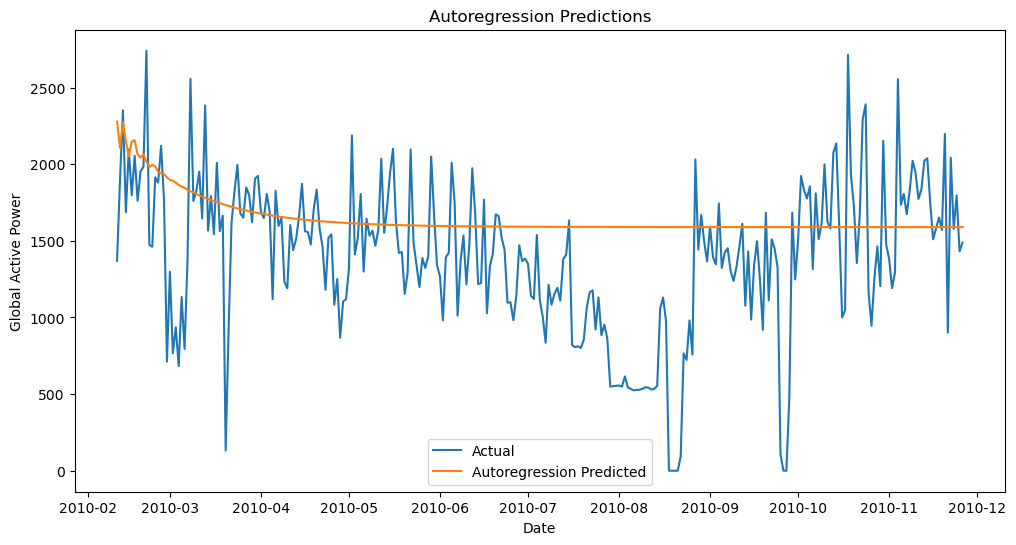

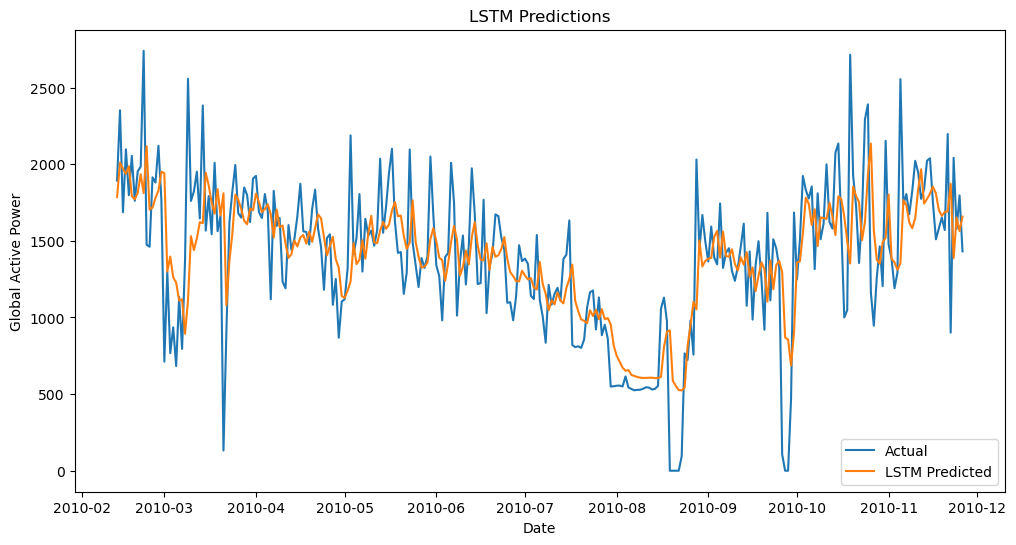

In [35]:
# Plot predictions for Autoregression
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index[-len(autoregression_actual):], scaler.inverse_transform(autoregression_actual), label='Actual')
plt.plot(daily_data.index[-len(autoregression_predictions):], scaler.inverse_transform(autoregression_predictions.reshape(-1, 1)), label='Autoregression Predicted')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('Autoregression Predictions')
plt.legend()
plt.show()

# Plot predictions for LSTM
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index[-len(lstm_actual):], scaler.inverse_transform(lstm_actual), label='Actual')
plt.plot(daily_data.index[-len(lstm_predictions):], scaler.inverse_transform(lstm_predictions), label='LSTM Predicted')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('LSTM Predictions')
plt.legend()
plt.show()

XGBoost Mean Squared Error: 517.1536927681071


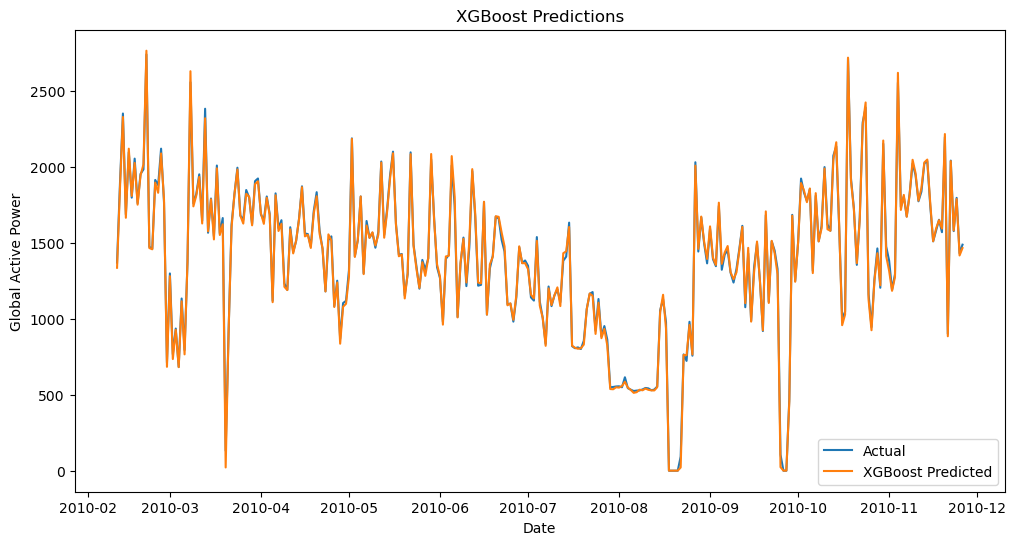

In [46]:
# XGboost
from xgboost import XGBRegressor

# Load the dataset
data = pd.read_csv('household_power_consumption.txt', sep=';', 
                   parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True,
                   na_values=['?'])

# Resample to daily data
daily_data = data.set_index('datetime').resample('D').sum()

# Select relevant variables
selected_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
data_selected = daily_data[selected_columns]

# Drop rows with missing values
data_selected.dropna(inplace=True)

# Split the data into train and test sets
train_size = int(0.8 * len(data_selected))
train, test = data_selected[:train_size], data_selected[train_size:]

# Prepare data for XGBoost
X_train, y_train = train.drop('Global_active_power', axis=1), train['Global_active_power']
X_test, y_test = test.drop('Global_active_power', axis=1), test['Global_active_power']

# Initialize and fit XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Forecast using XGBoost model
forecast = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, forecast)
print(f'XGBoost Mean Squared Error: {mse}')

# Plot predictions for XGBoost
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Global_active_power'], label='Actual')
plt.plot(test.index, forecast, label='XGBoost Predicted')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('XGBoost Predictions')
plt.legend()
plt.show()

VAR Root Mean Squared Error: 10231.261374304444


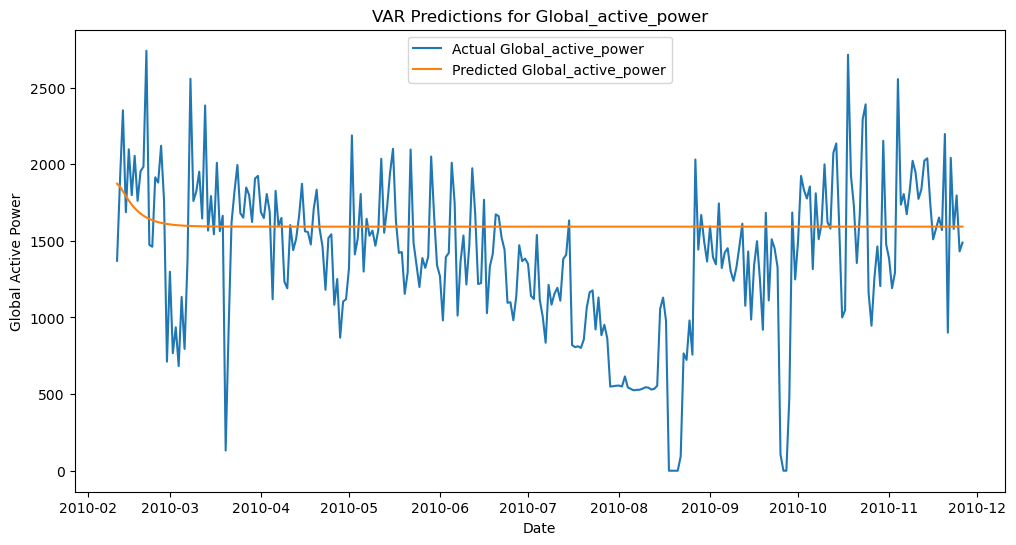

In [52]:
# VAR

from statsmodels.tsa.api import VAR


# Train VAR model
model = VAR(train)
model_fit = model.fit()

# Forecast using VAR model
forecast = model_fit.forecast(train.values[-model_fit.k_ar:], steps=len(test))

# Calculate Mean Squared Error
mse = mean_squared_error(test, forecast, squared=False)
print(f'VAR Root Mean Squared Error: {mse}')

# Plot predictions for VAR
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Global_active_power'], label='Actual Global_active_power')
plt.plot(test.index, forecast[:, selected_columns.index('Global_active_power')], label='Predicted Global_active_power')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('VAR Predictions for Global_active_power')
plt.legend()
plt.show()